In [1]:
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
model = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.2', output_attentions=True)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_attention(attention_df, predict, context_series, figsize=(20, 12), word_space=0.01, line_space=0.02, margin=0.05, dpi=100, save=True, filename='attention_plot.png'):
    # Validate input data
    if not isinstance(attention_df, pd.DataFrame) or not all(col in attention_df.columns for col in ['normalized_word_weight', 'raw_word']):
        raise ValueError('attention_df must be a pandas DataFrame with columns "normalized_word_weight" and "raw_word"')

    if not isinstance(figsize, (tuple, list)) or len(figsize) != 2:
        raise ValueError('figsize must be a tuple or list of two values')

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_xlim(0, 1)
    ax.axis('off')
    plt.text(0.5, 1.05, f"Predict: {predict:.2f}", ha='center', va='bottom', transform=ax.transAxes, fontsize=16)
    plt.text(0.5, 1.025, f"True Label: {context_series['label']}", ha='center', va='bottom', transform=ax.transAxes, fontsize=16)

    x_pos, y_pos = margin, 1 - margin - 0.1 
    max_height = 0

    attention_weights = attention_df['normalized_word_weight'] / attention_df['normalized_word_weight'].max()
    norm = mcolors.Normalize(vmin=attention_weights.min(), vmax=attention_weights.max())
    sm = cm.ScalarMappable(cmap='Reds', norm=norm)

    for word, weight in zip(attention_df['raw_word'], attention_weights):
        color = sm.to_rgba(weight)
        text = ax.text(x_pos, y_pos, word, ha='left', va='bottom', fontsize=12, weight='bold', color='black', bbox=dict(facecolor=color, alpha=1, boxstyle='round,pad=0.5'))

        fig.canvas.draw()
        bbox = text.get_window_extent()
        bbox_data = bbox.transformed(ax.transData.inverted())

        if bbox_data.x1 > 1 - margin:
            y_pos -= max_height + line_space
            x_pos = margin
            max_height = 0

        x_pos += bbox_data.width + word_space
        max_height = max(max_height, bbox_data.height)

        if y_pos < 0 + margin:
            break

    # Adjust the size and padding of the color bar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.01)
    cbar.ax.set_ylabel('Attention Weight')

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


In [3]:
import torch

# Prepare data
def plots(text,filename):
    texts=[text]
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", return_attention_mask=True)

    with torch.no_grad():
        outputs = model(**inputs)

    attention = outputs.attentions[-1]
    attention_weights = attention.mean(dim=1)  
    diagonal_attention = attention_weights[:, range(attention_weights.size(1)), range(attention_weights.size(1))]
    # Example of averaging token attention weights for each sentence
    sentence_attention_weights = []
    for i, text in enumerate(texts):
        token_attention_weights = diagonal_attention[i].tolist()
        average_attention = sum(token_attention_weights) / len(token_attention_weights)
        sentence_attention_weights.append(average_attention)

    attention_data = []
    for i, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        weights = diagonal_attention[i].tolist()[:len(tokens)]  # Truncate to the length of the number of tokens
        sentence_att_weight = sentence_attention_weights[i]  # Sentence-level attention weight
        for token, weight in zip(tokens, weights):
            attention_data.append({
                'sent_id': text,
                'raw_word': token,
                'normalized_word_weight': weight,
                'sent_att_weight': sentence_att_weight
            })

    attention_df = pd.DataFrame(attention_data)
    predict = 0.5
    context_series = pd.Series({'label': 'Positive', 'name': 'Patient History'})

    plot_attention(attention_df, predict, context_series,filename=filename)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


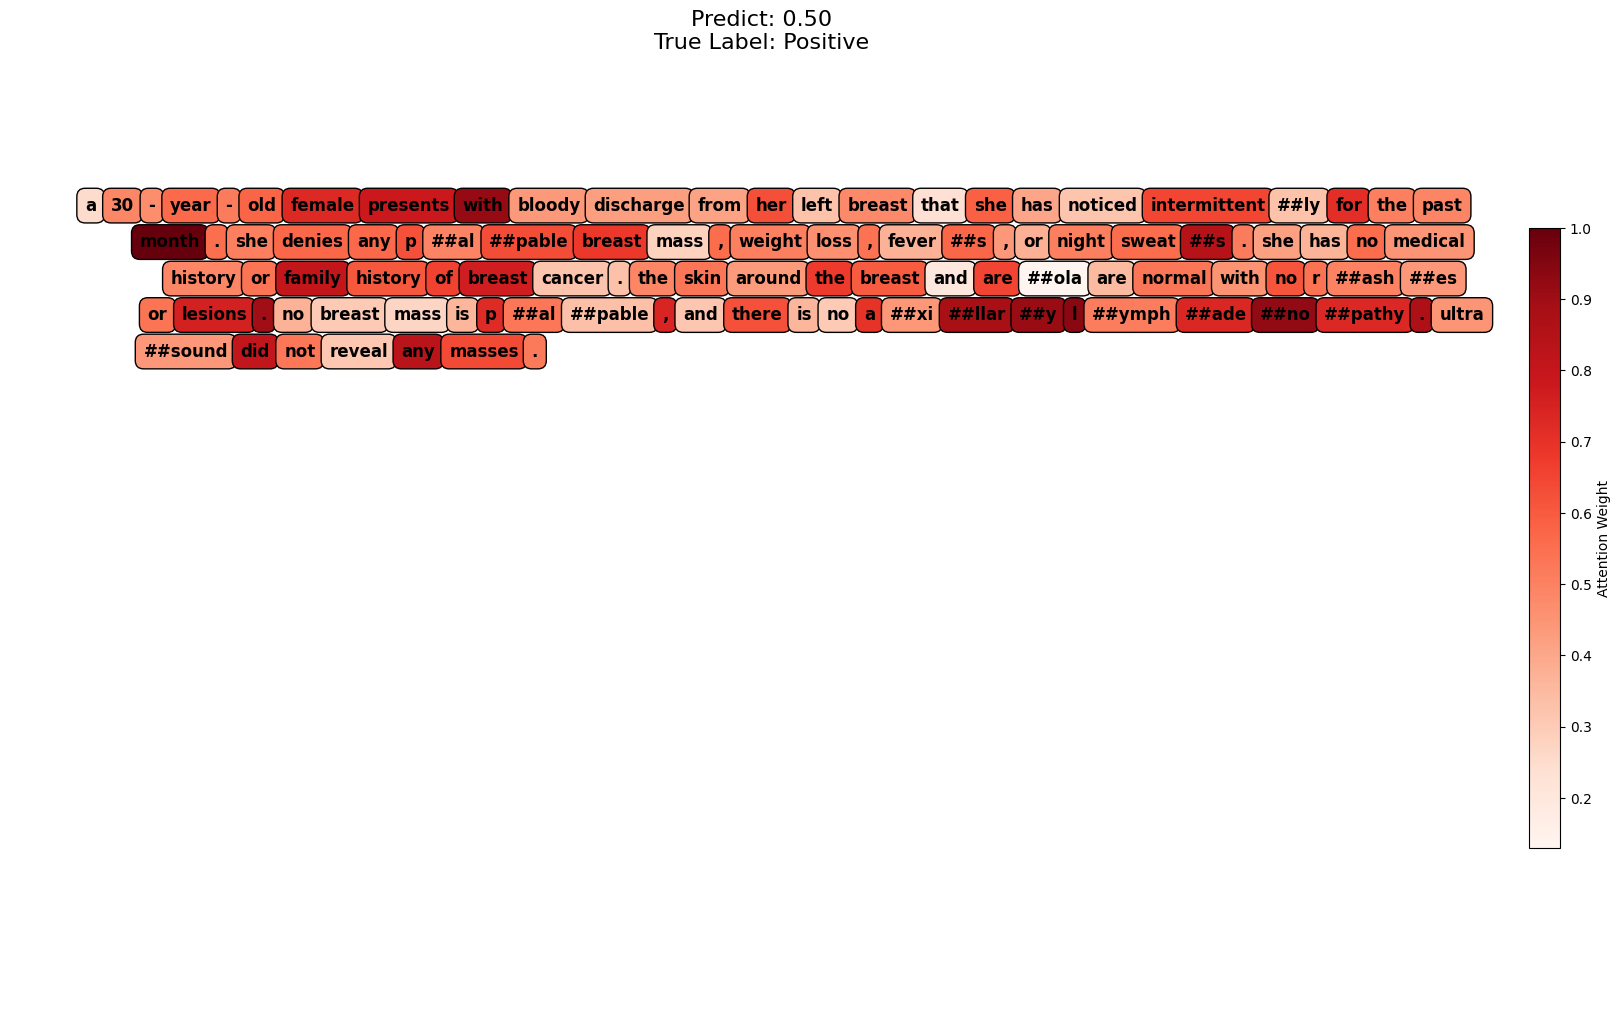

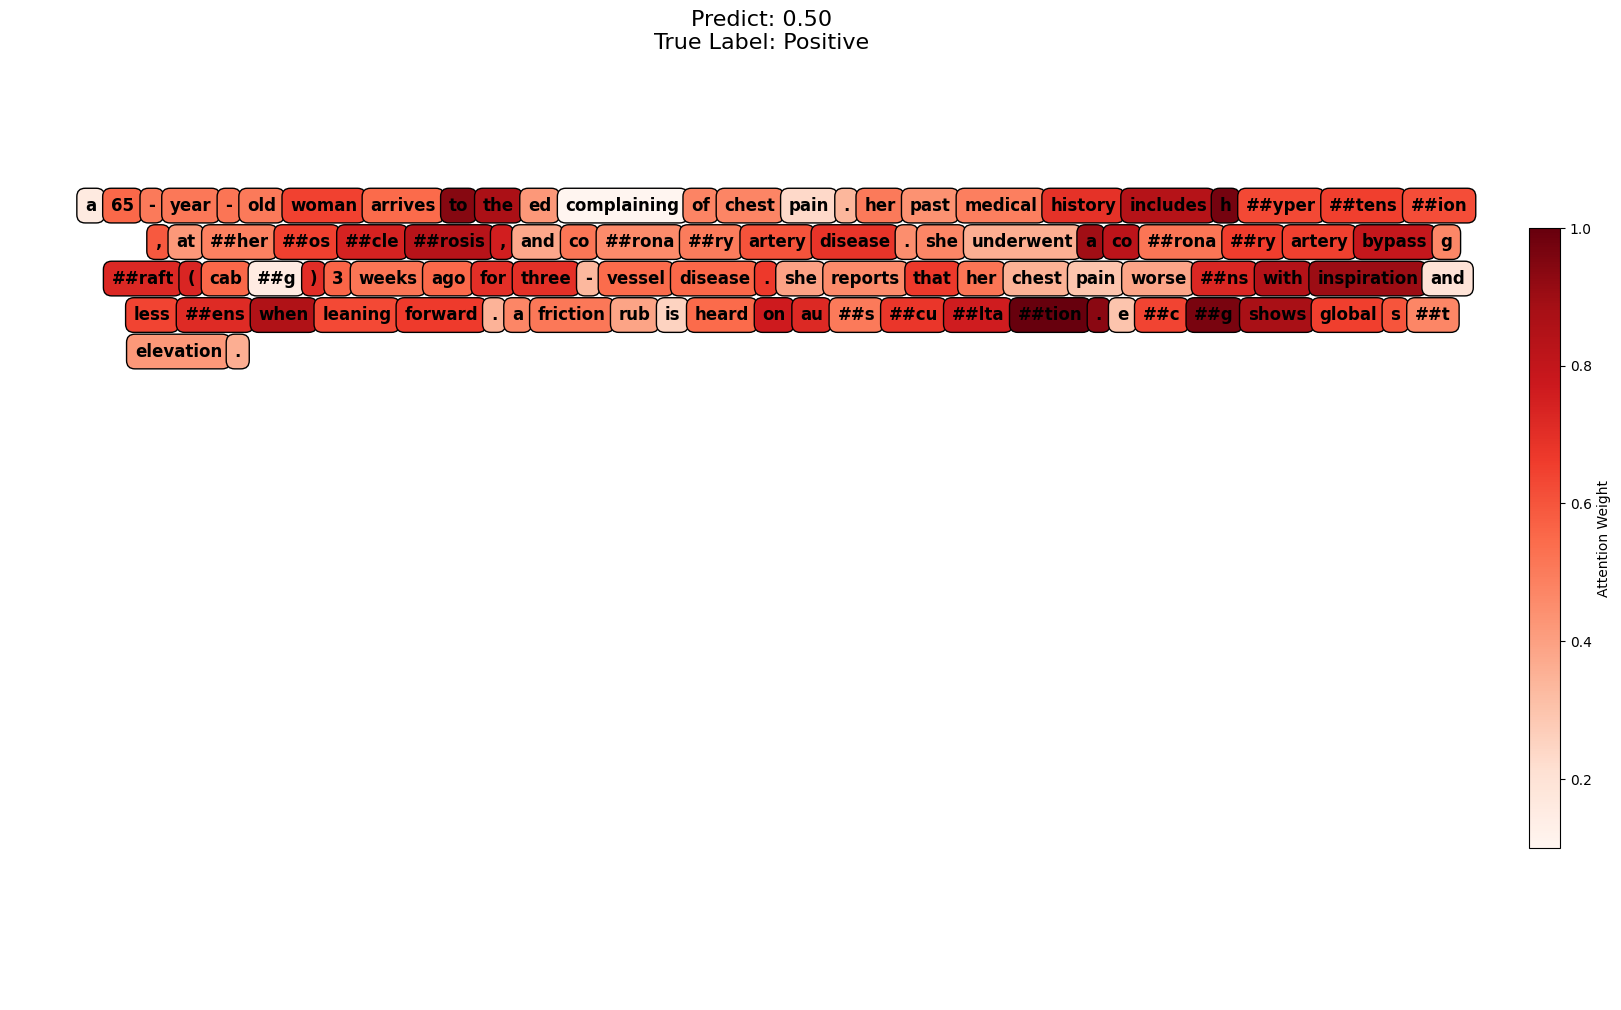

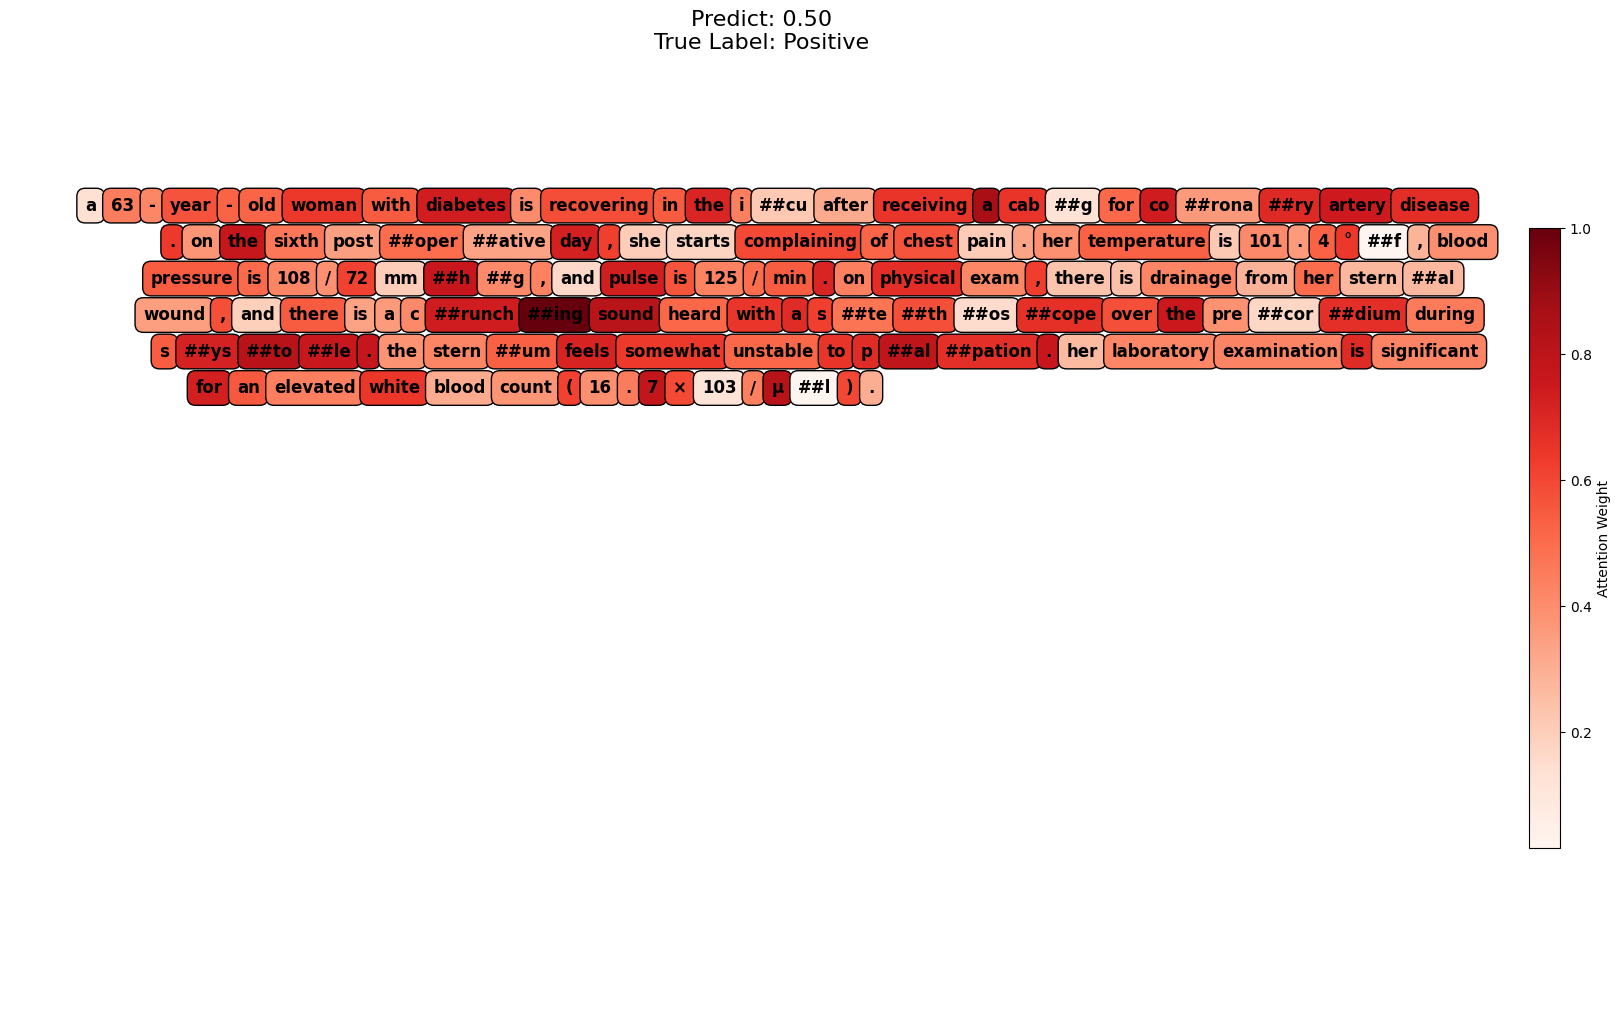

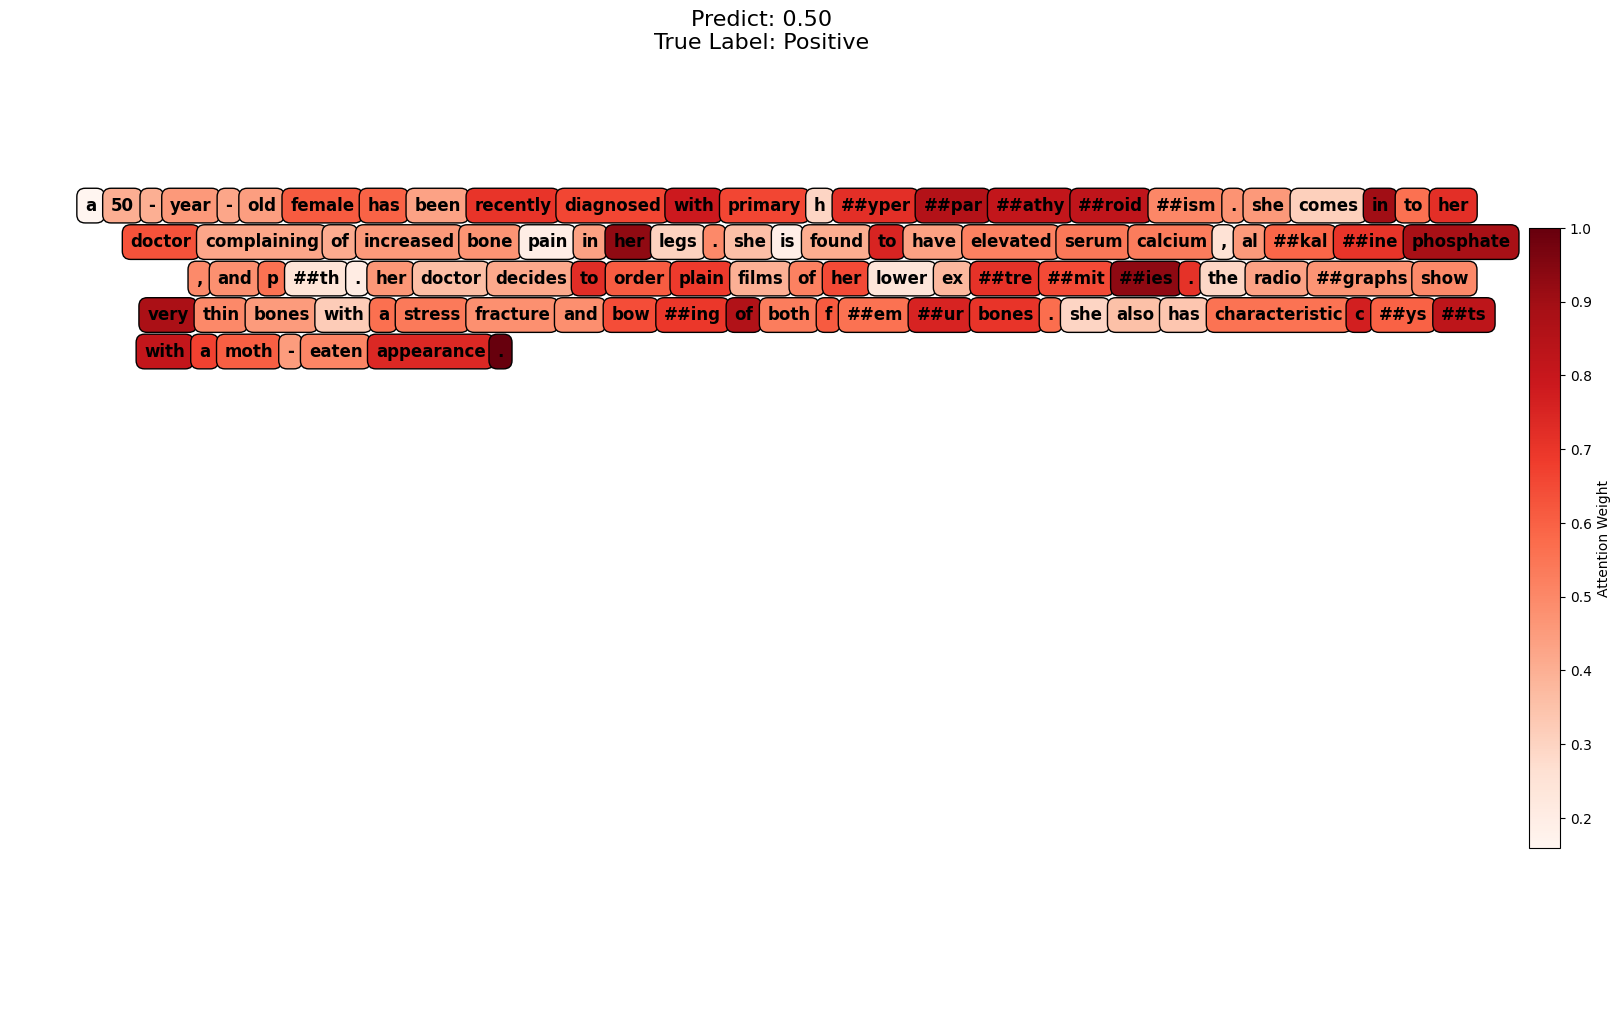

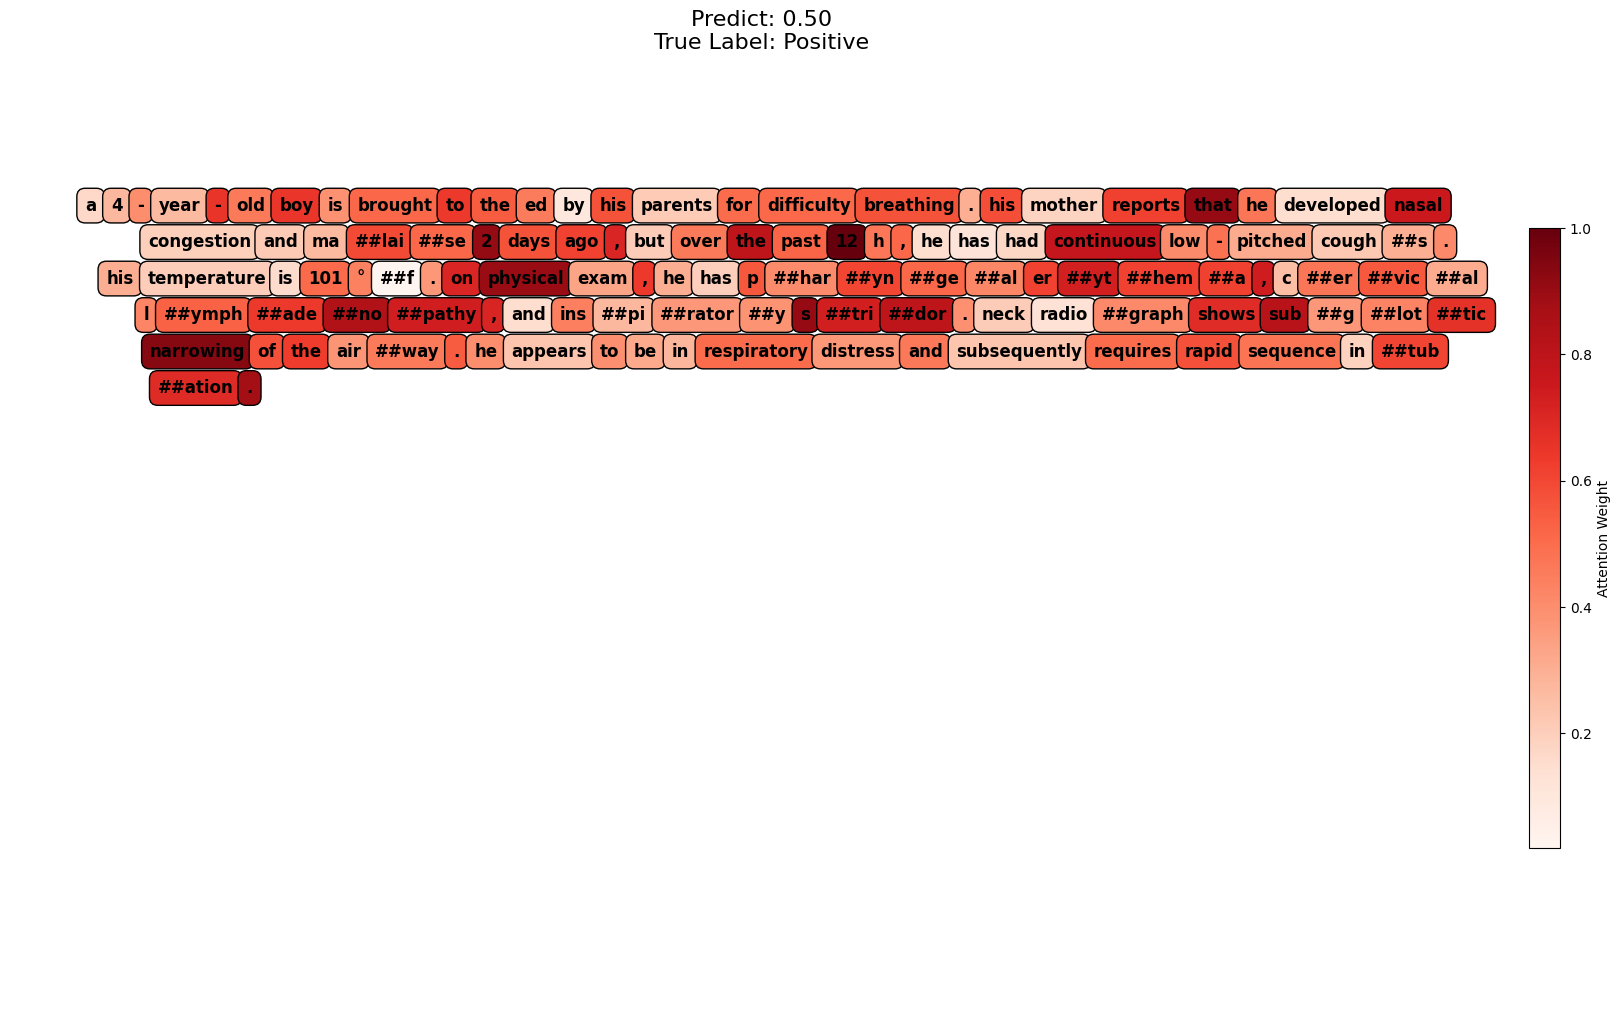

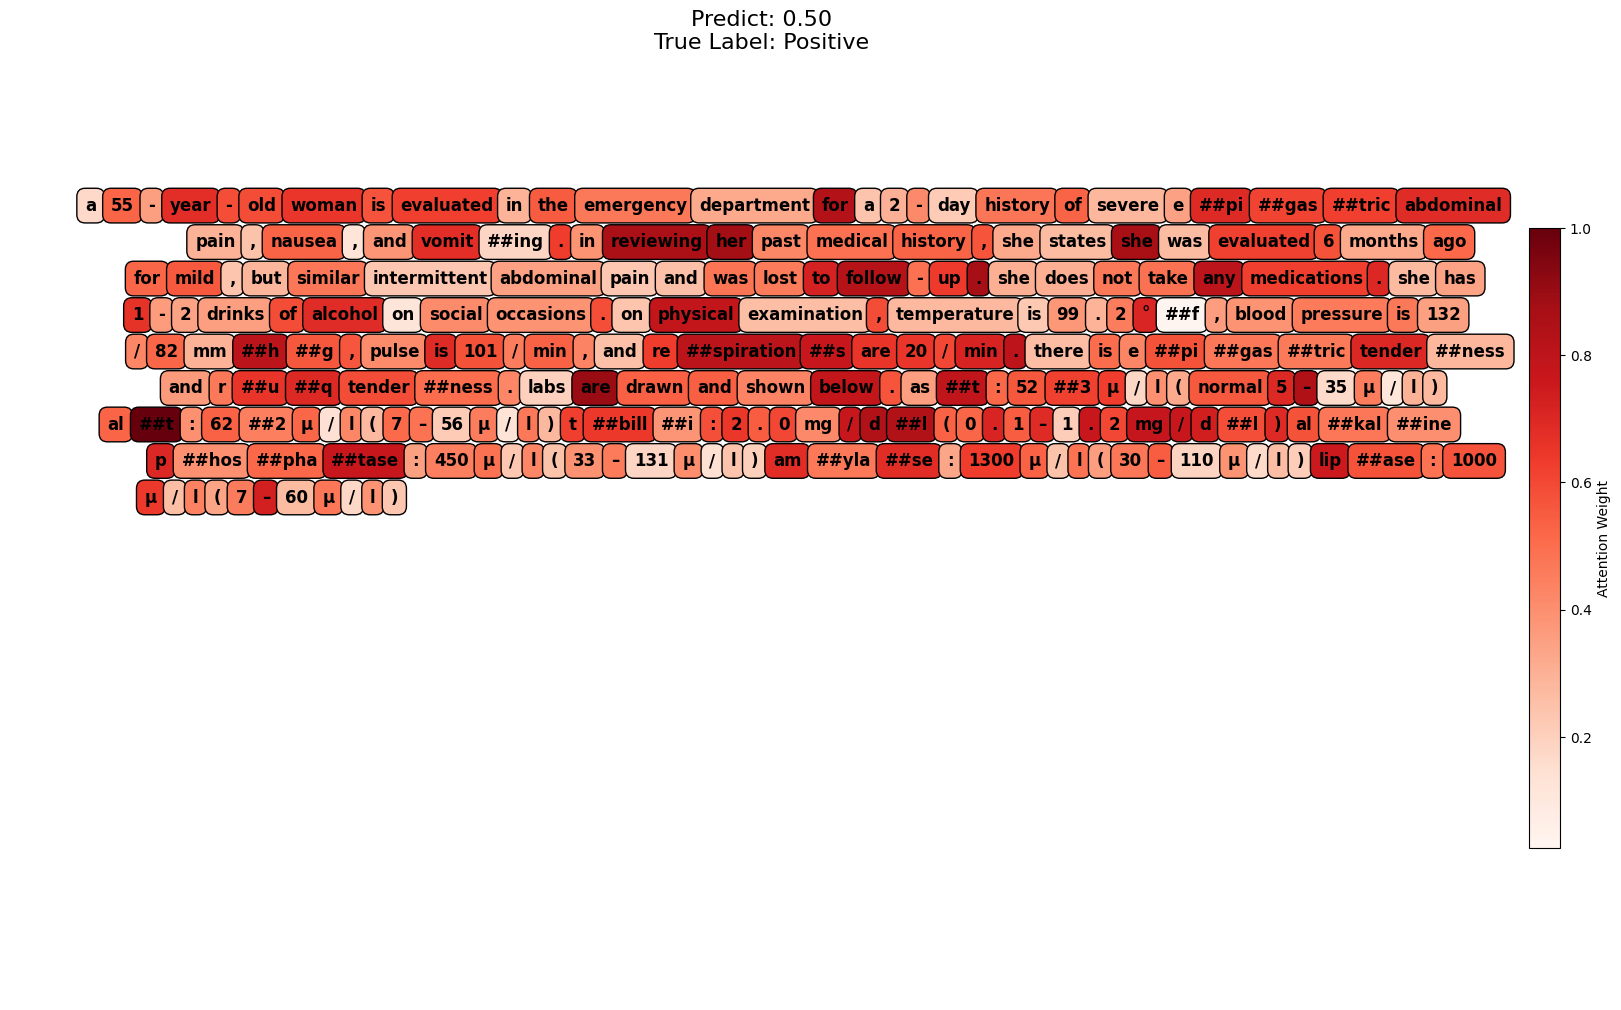

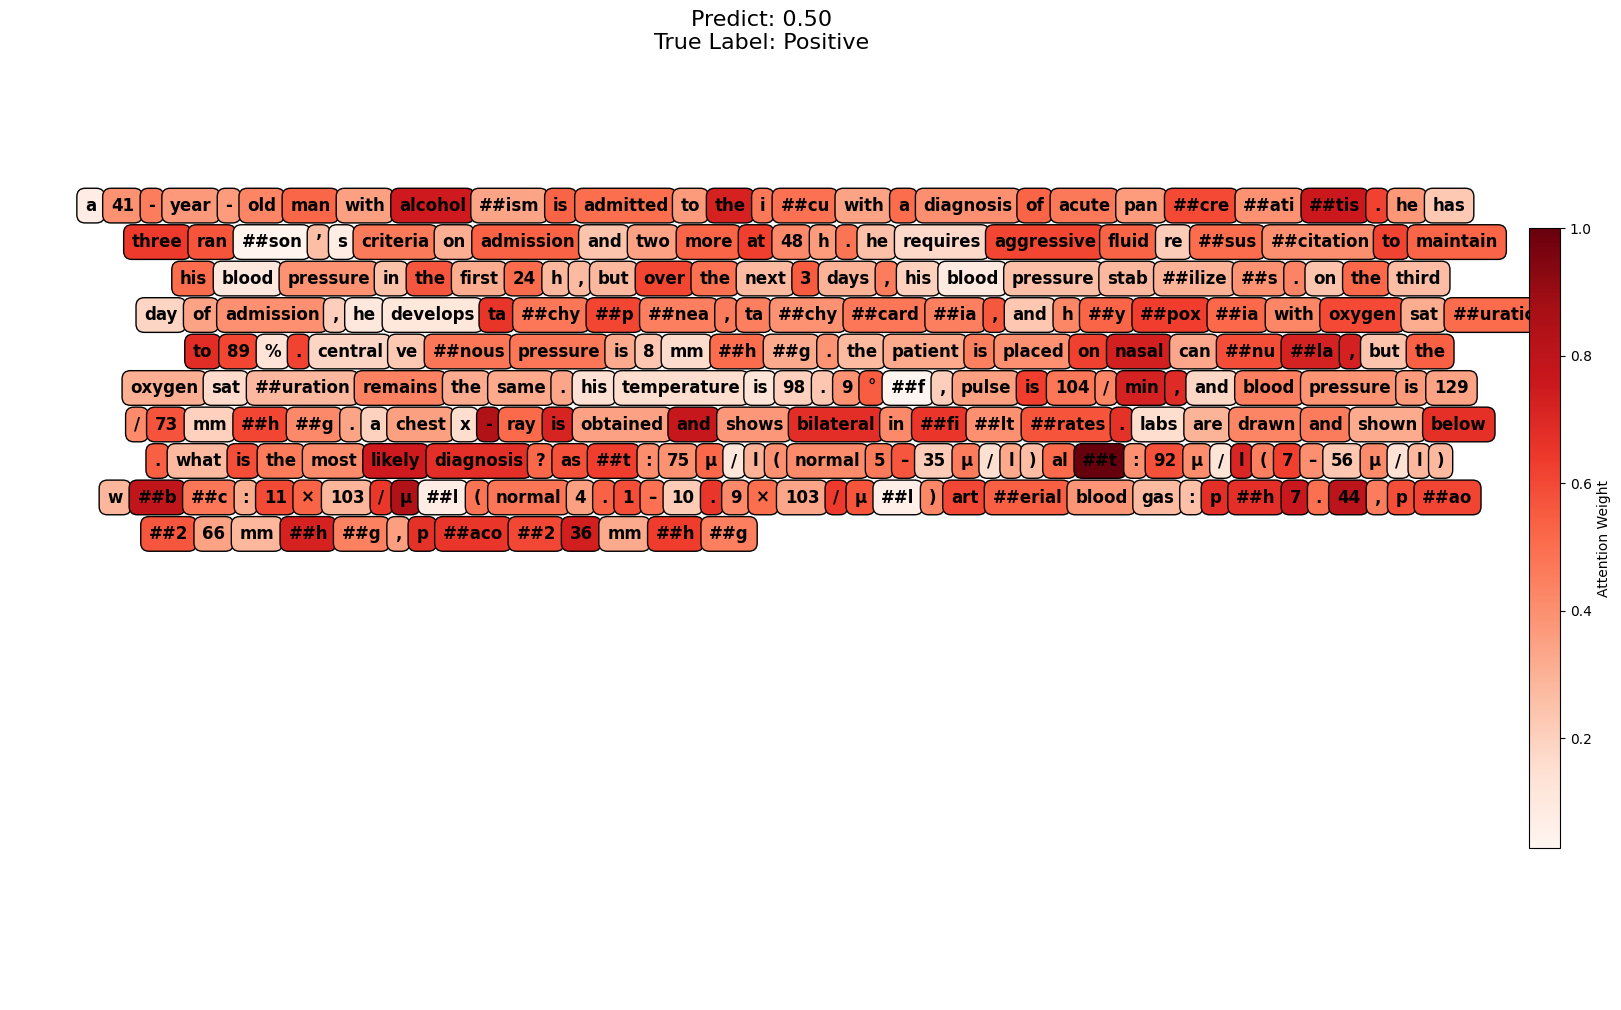

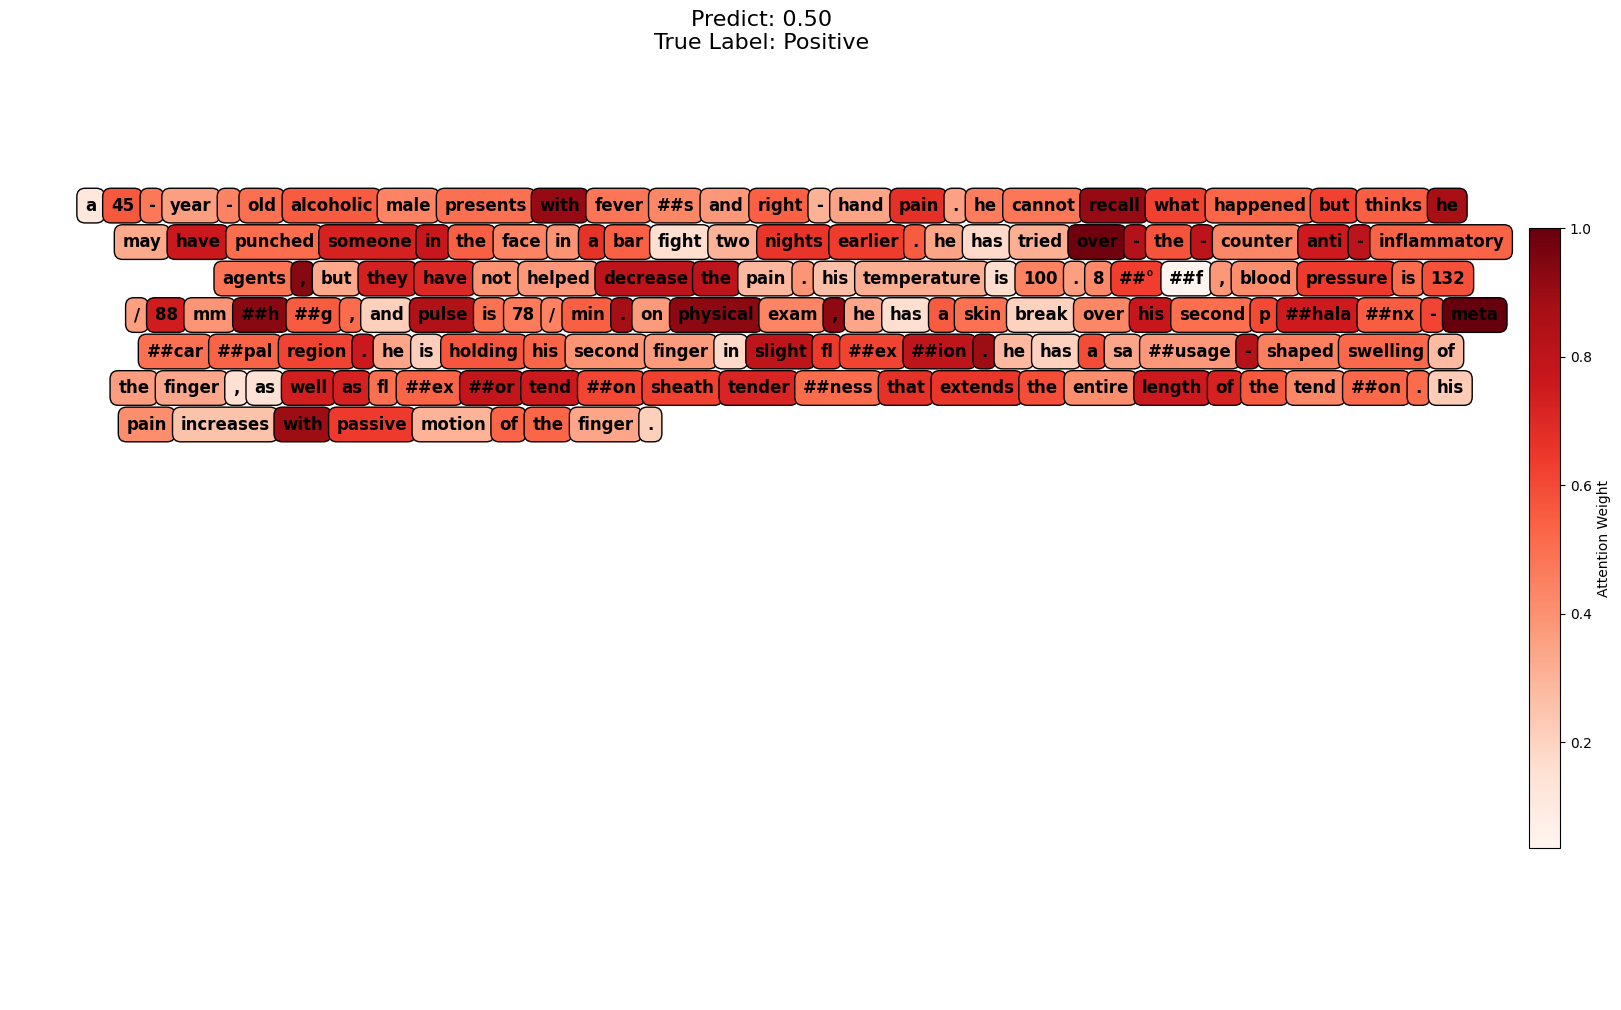

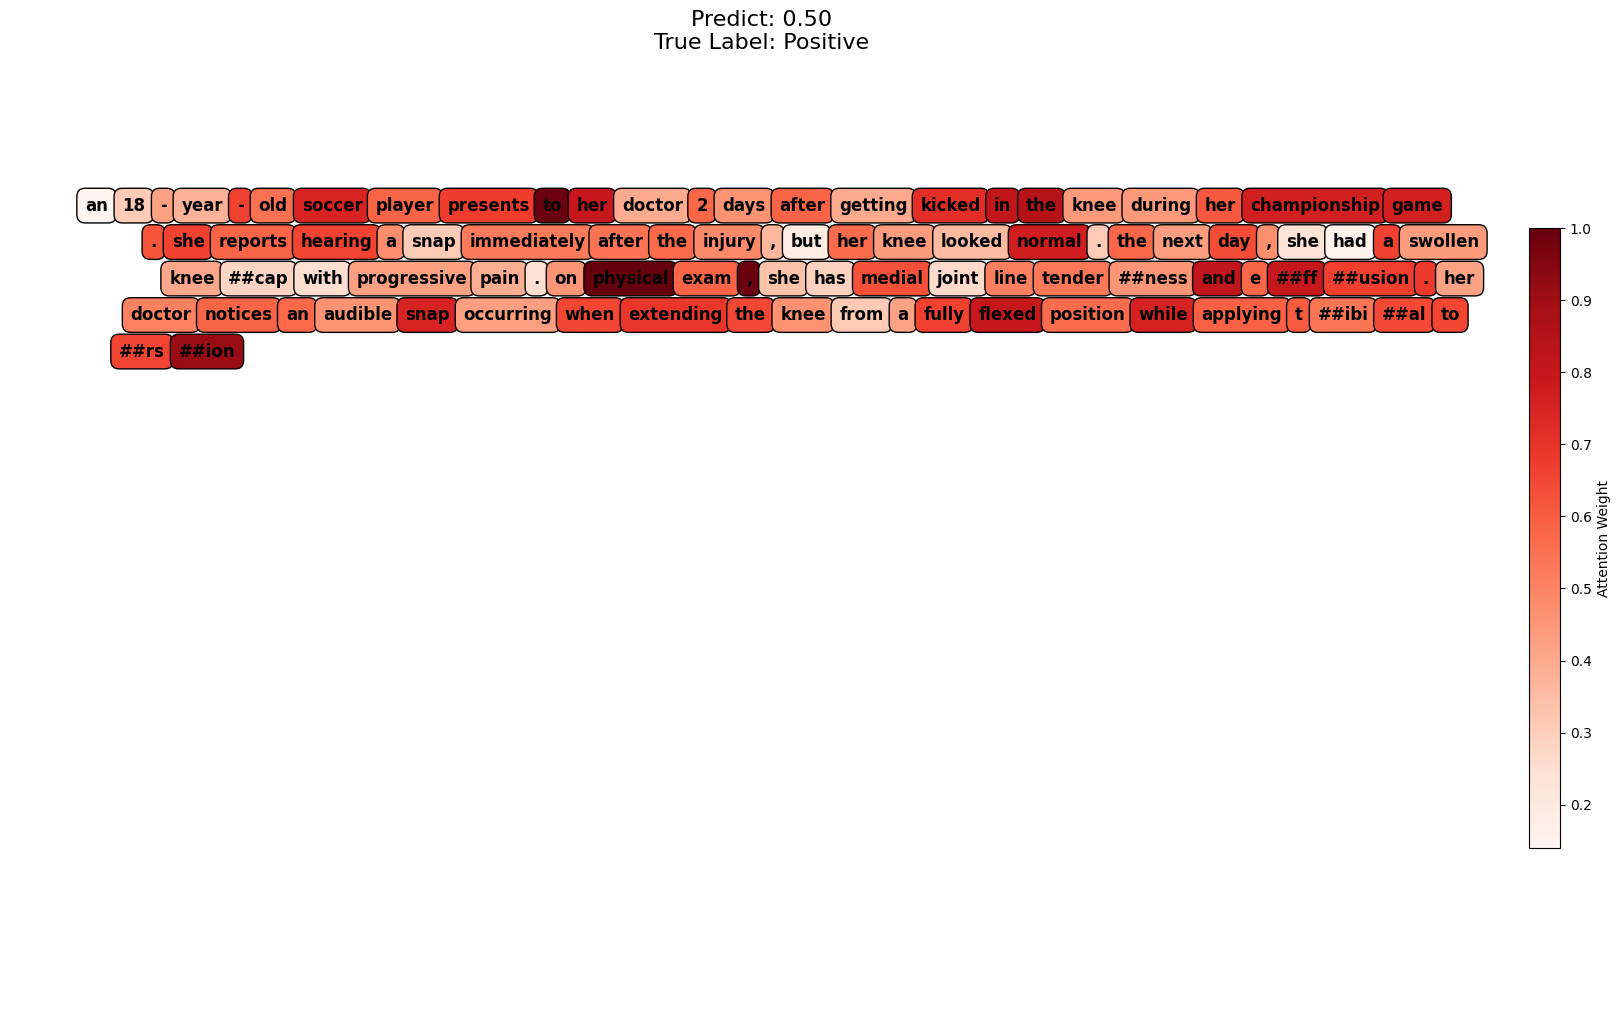

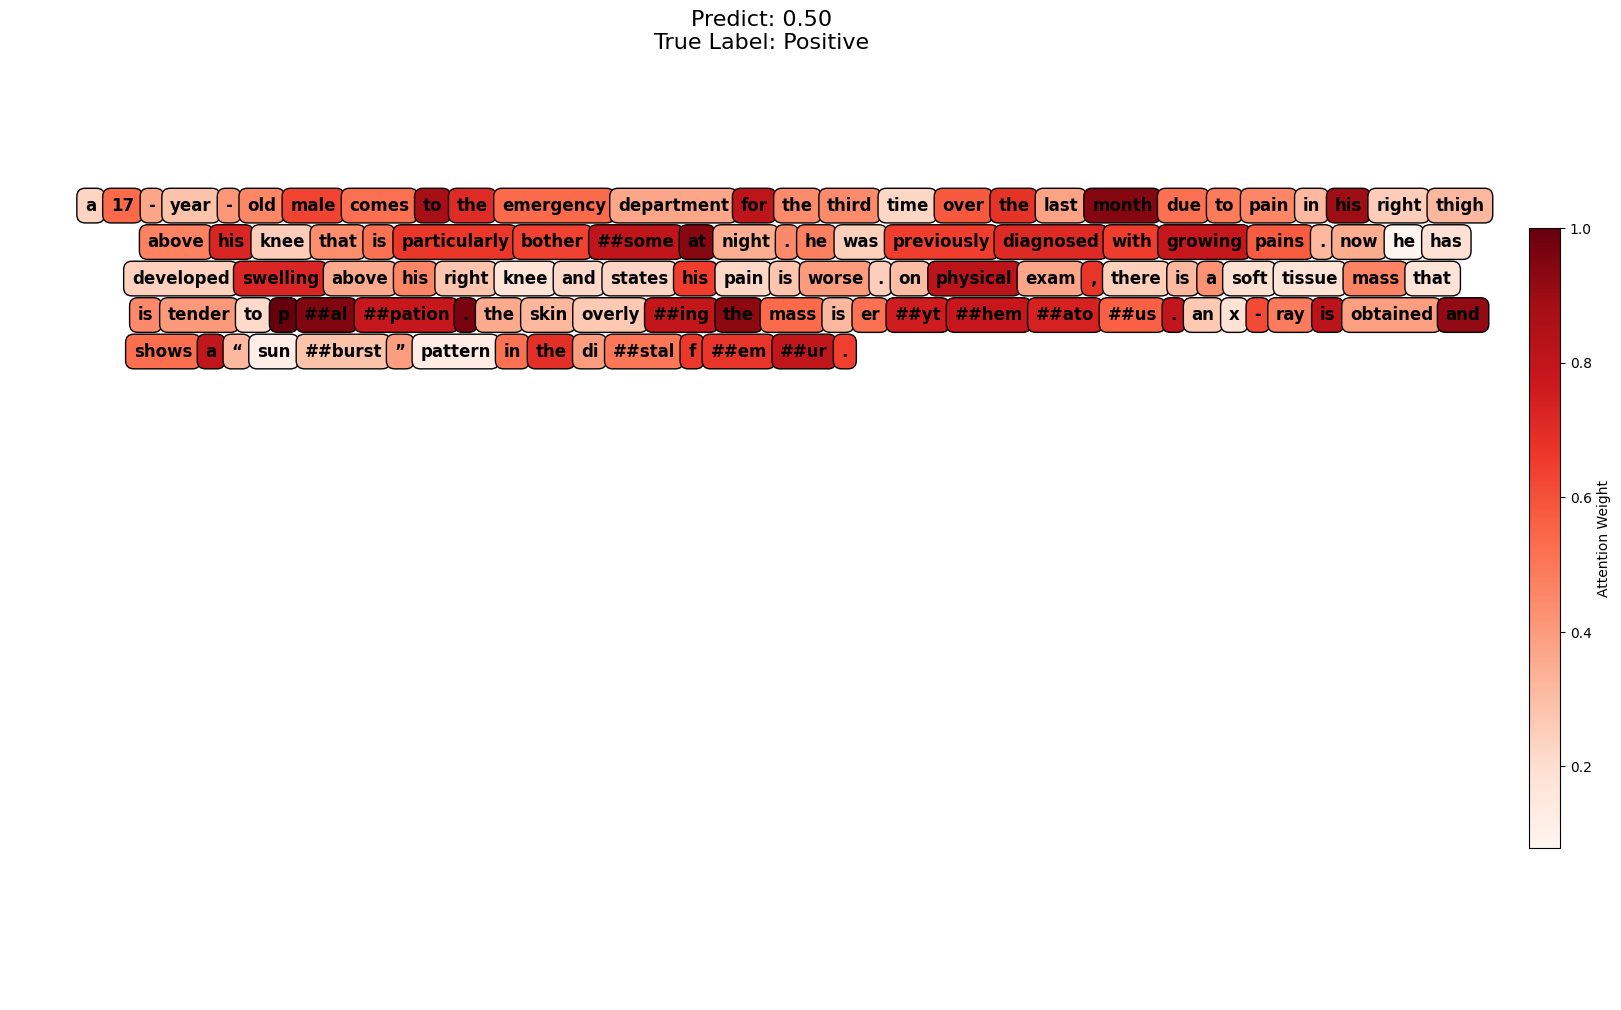

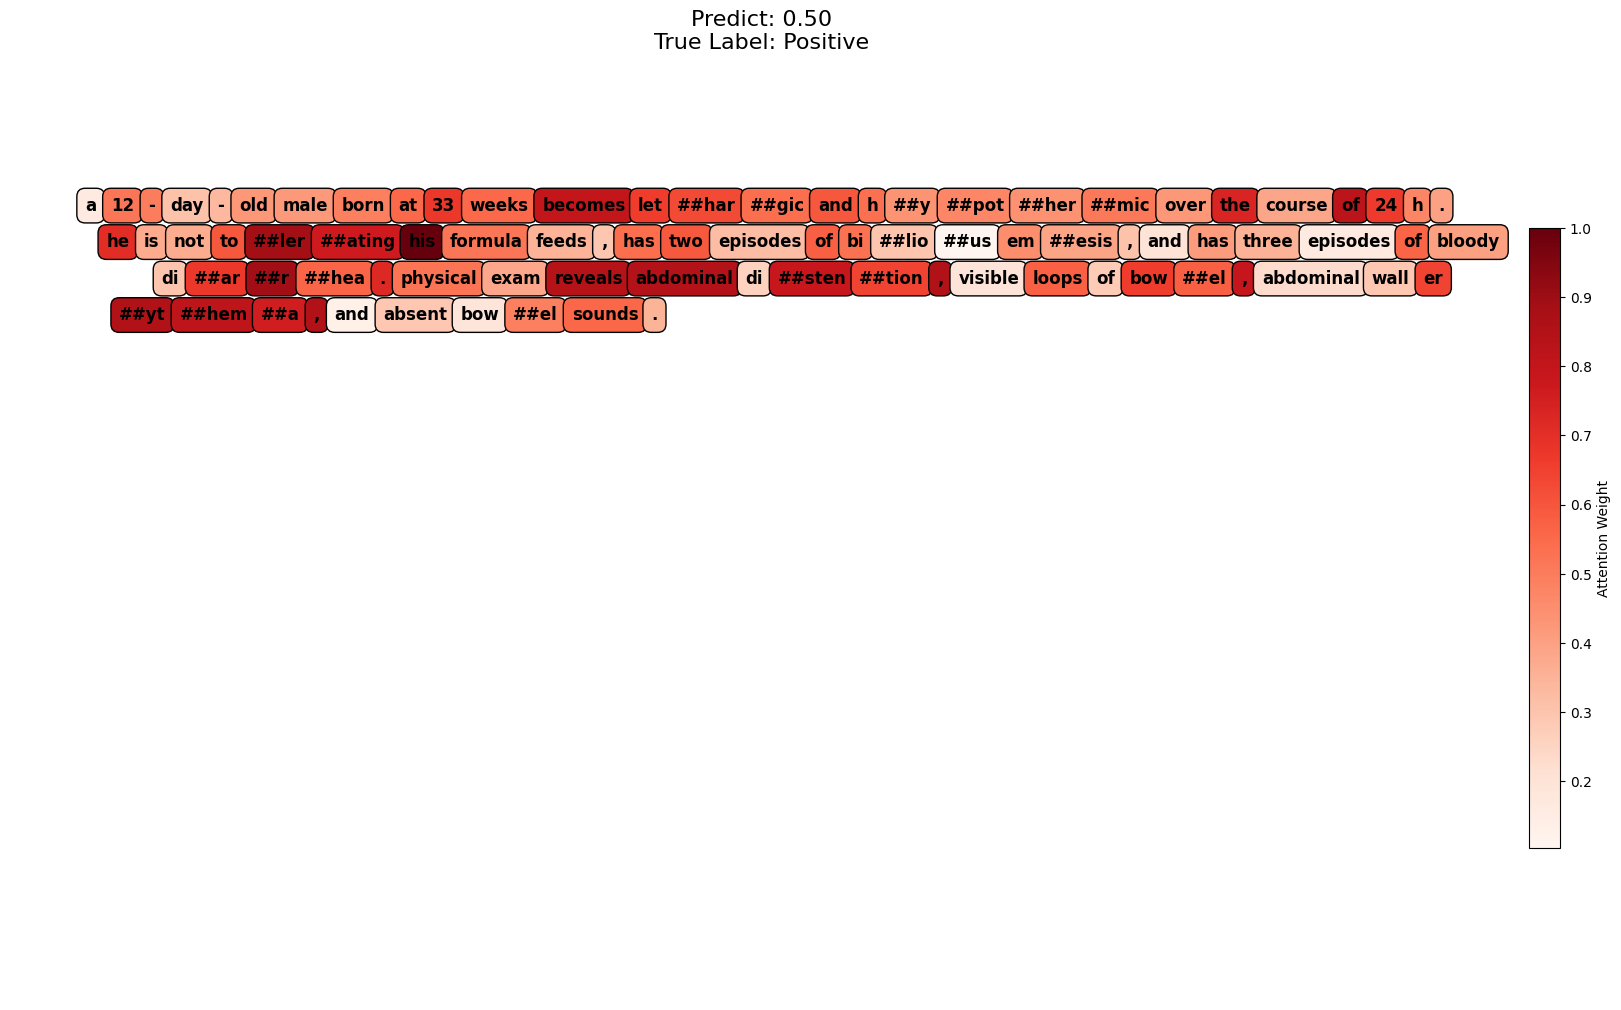

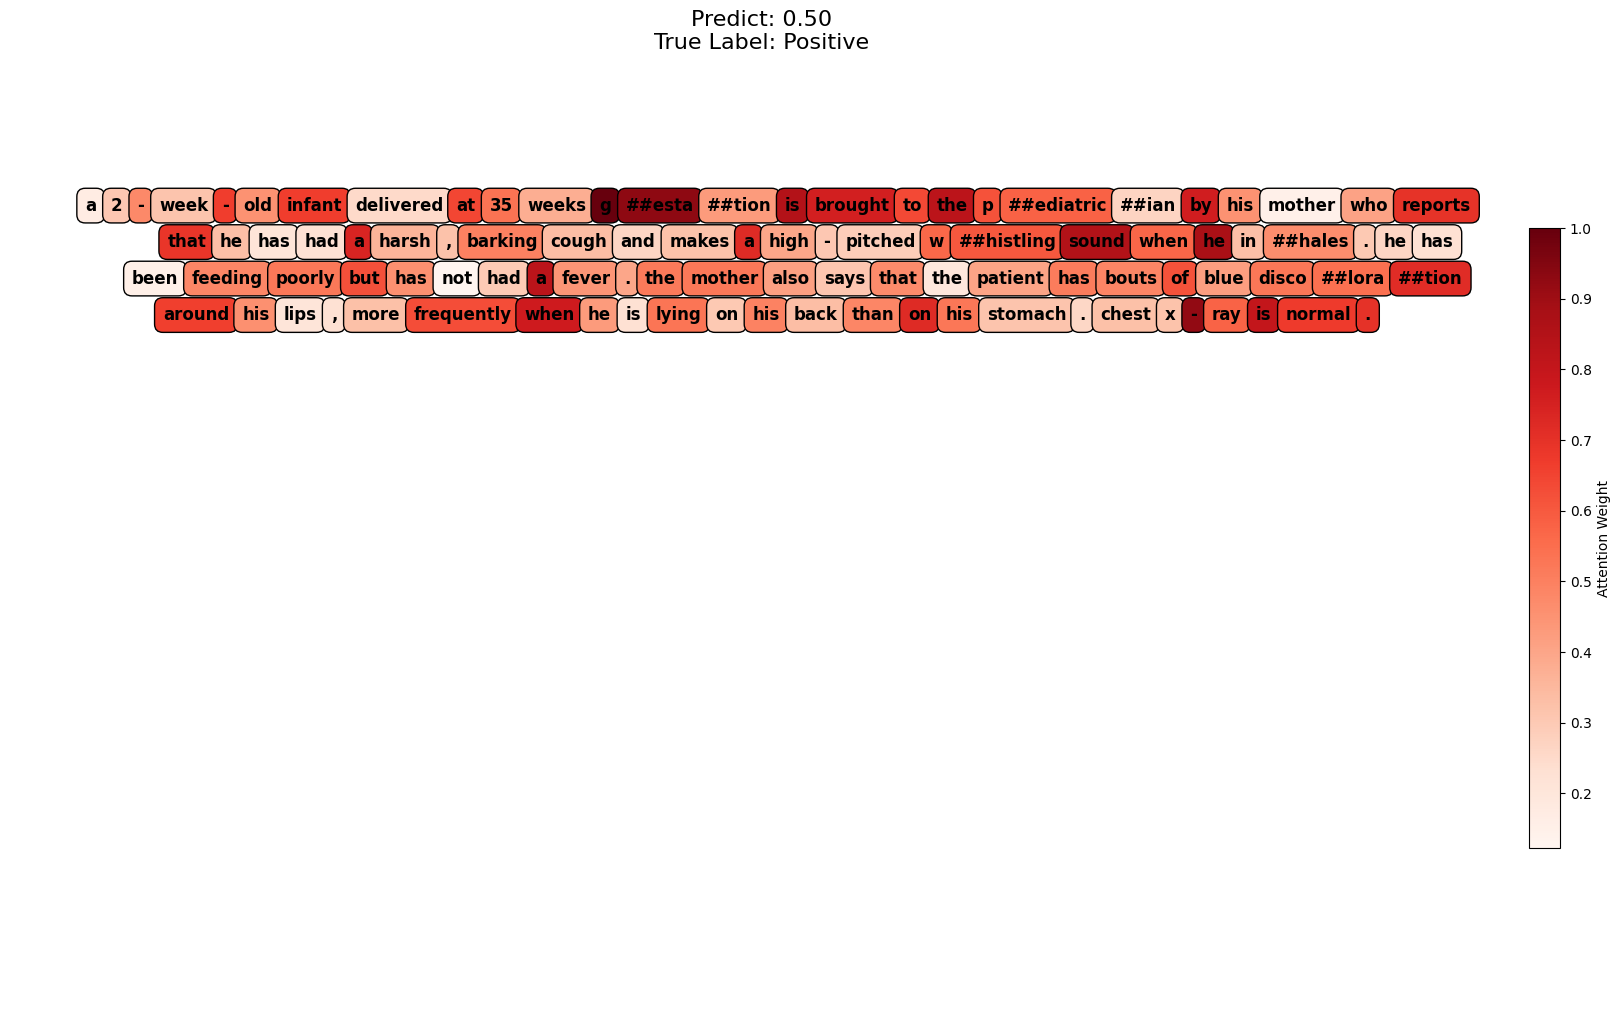

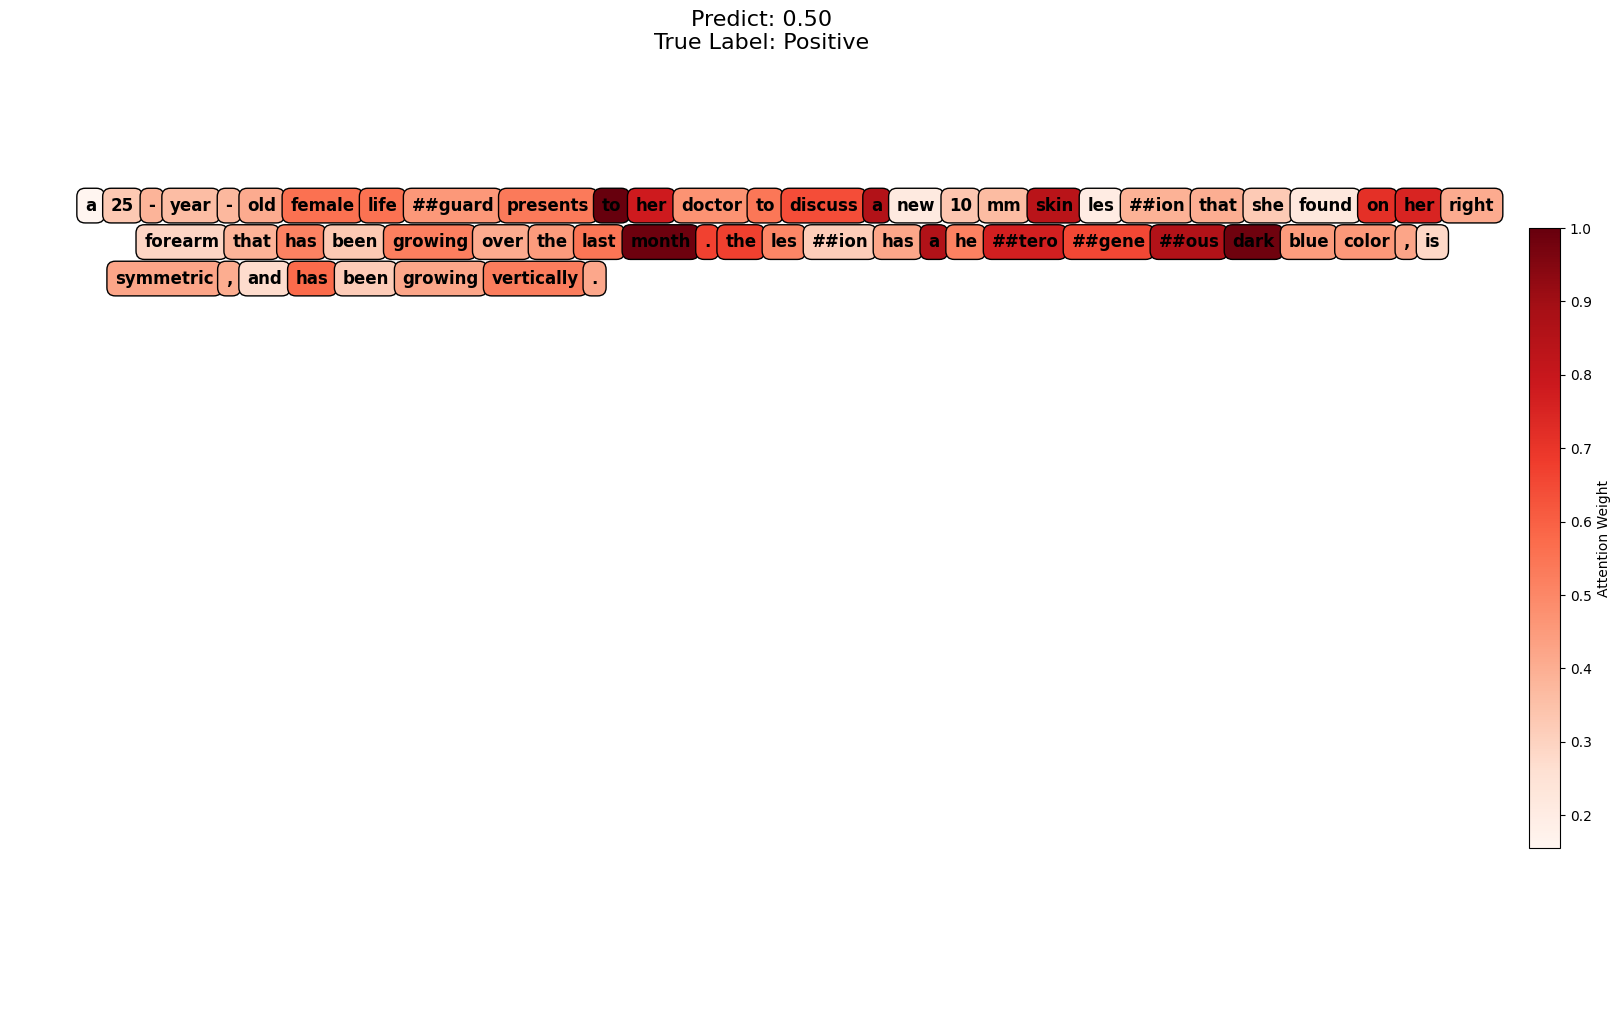

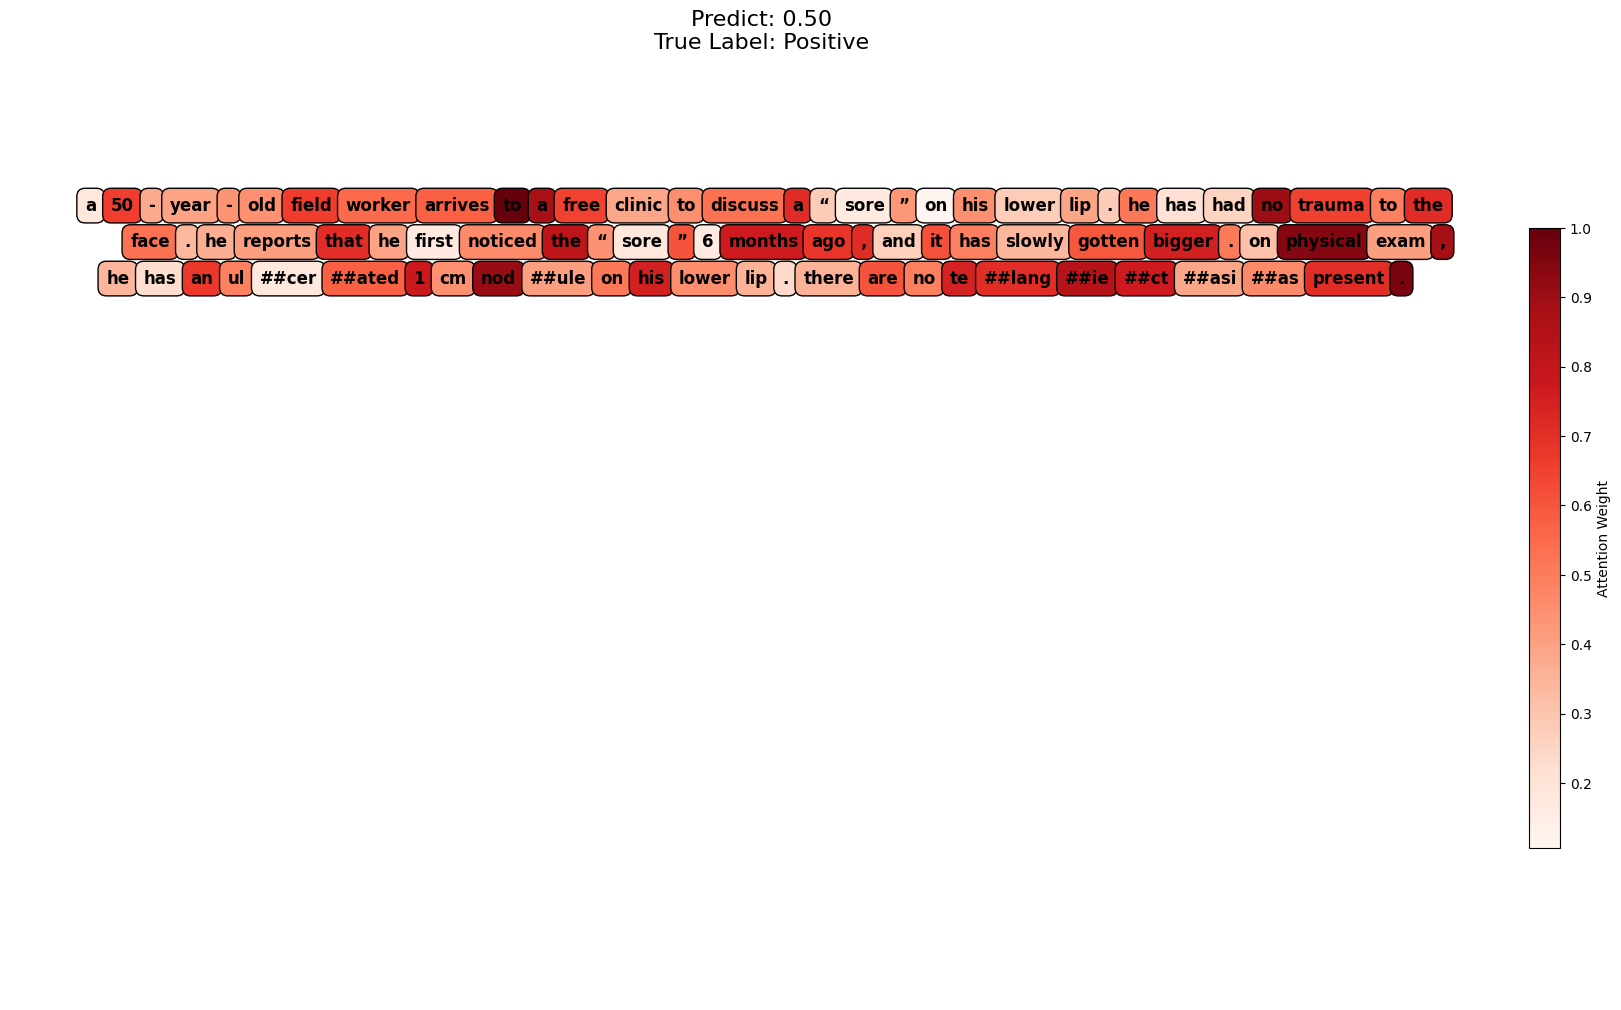

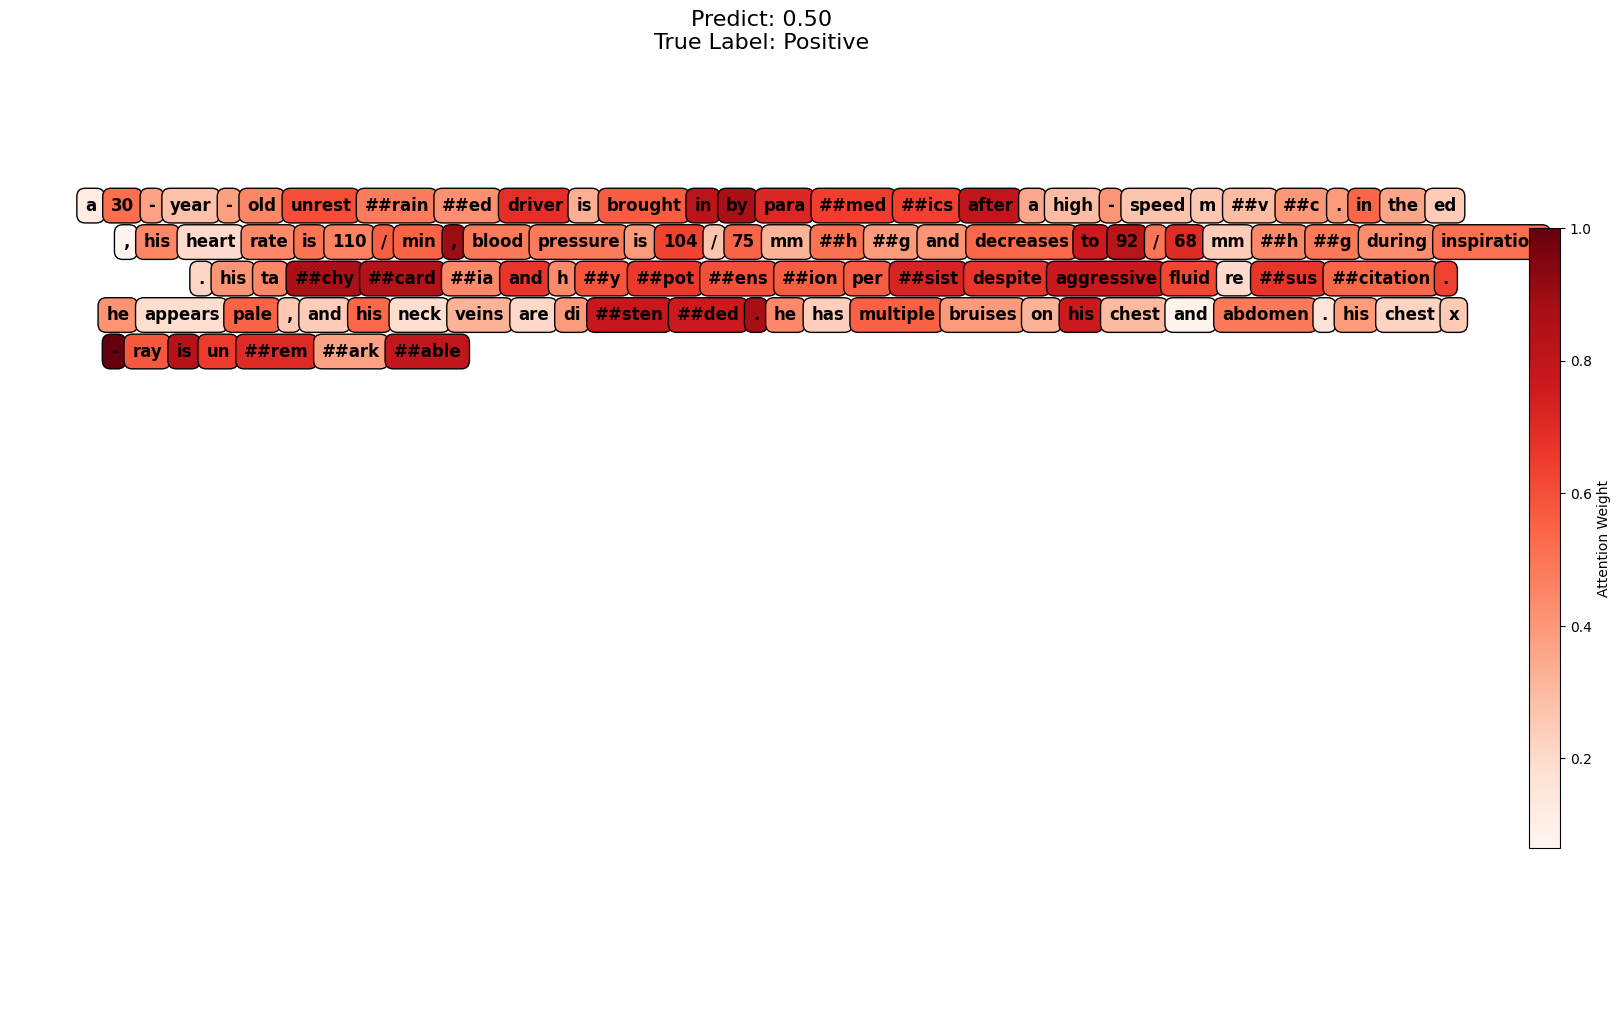

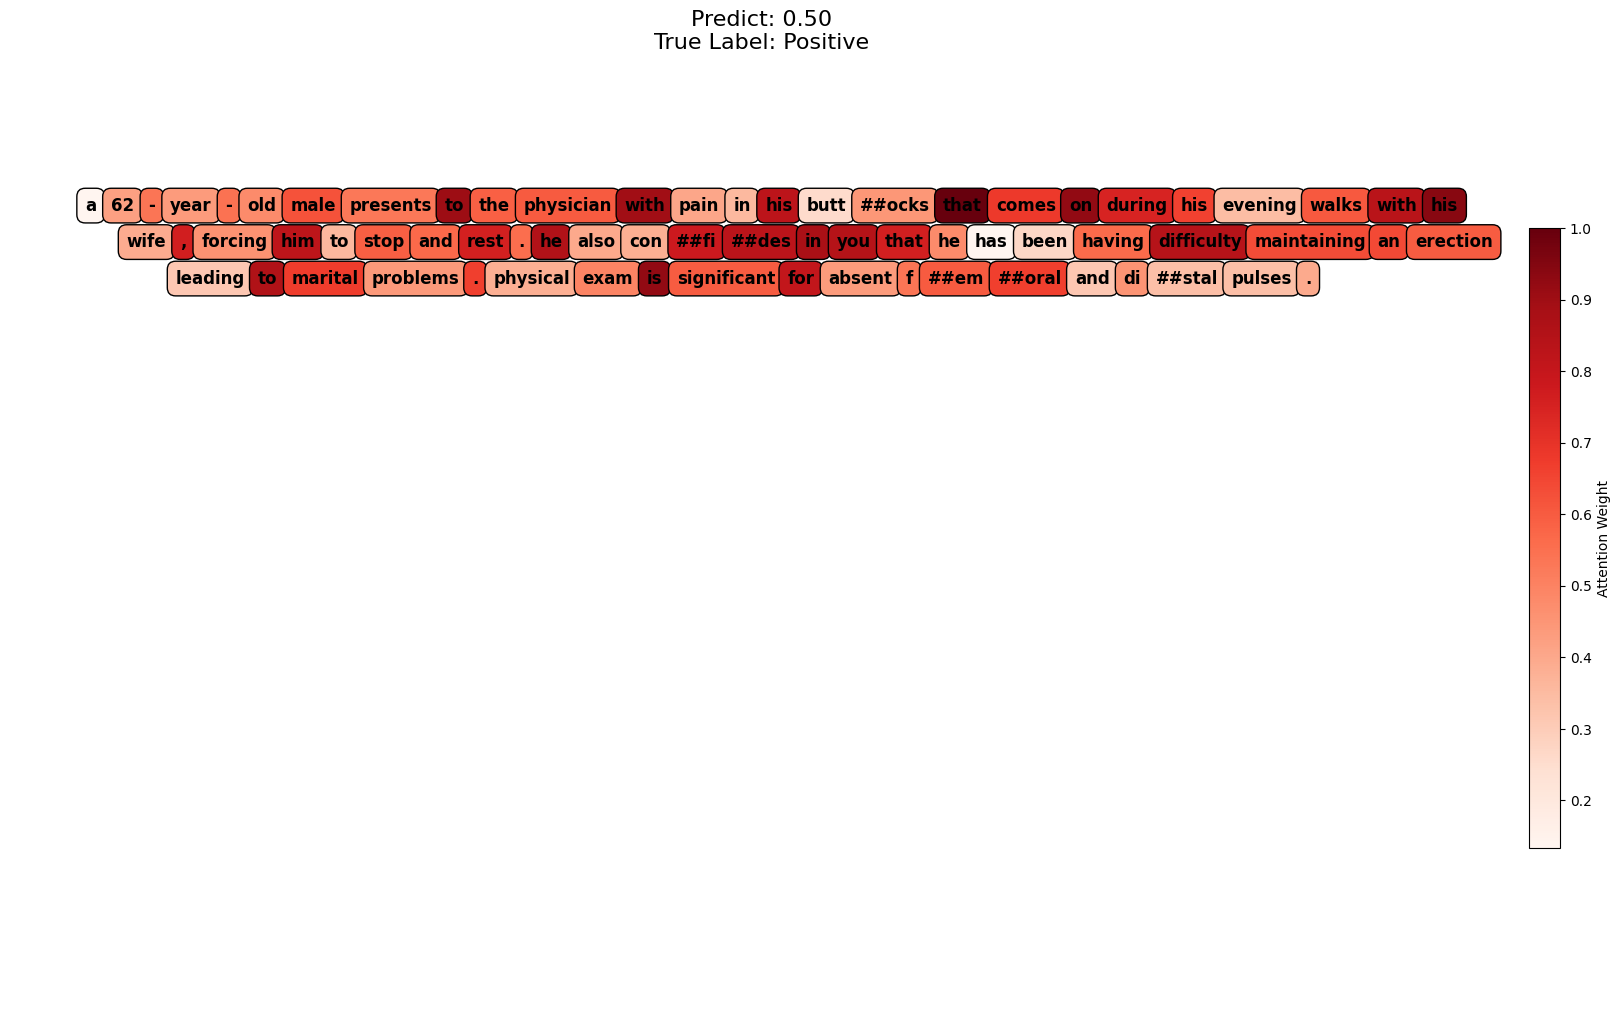

In [4]:
patient_histories = pd.read_csv("/kaggle/input/complete-dataset/Patient_Histories_Cleaned.csv")
for index, row in patient_histories.iterrows():
        results = []
        patient_id = index+1
        patient_history = row['Patient History']
        diagnosis = row['Diagnosis']
        plots(patient_history,f'patient-{patient_id}-BioBert-Attention.png')
        